# Table of Contents
###1 Overview
###2 Notebook Configuration
>2.1  Google drive

>2.2  Warning

>2.3  Matplotlib

>2.4  TensorFlow

>2.5  Random seed

###3  Data Preprocessing
>3.1  Extra Utilities

>3.2  Loading data

>3.2  Getting the name of the target

>3.3  Splitting the data

>3.4 Experiment Setup

>3.5 Identifying and dropping uncommon features

>3.6 Handling missing data

>3.7 Identifying missing values

> 3.8 Data Preparation for RNN

>3.9 Normalize the data


###4  Training
>4.1  Creating the directory for the model

>4.2  Building the architecture of LSTM model

>4.3  Setting Callbacks

>4.4  Compiling the model

>4.5  Training the model

>4.6  Plotting the learning curve

###5  Testing
>5.1 Reshaping test features 

>5.2  Loading the saved model

>5.3  Predicting values for the test dataset

>5.4  Generating the submission file

###6 Conclusion

###7  Reference





<b>
<p>
<center>
<font size='5'>
Detecting the Higgs Boson with RNN
</font>
</center>
</p>

    
<p>
<center>
<font size='4'>
GROUP - 4
</font>
</center>
</p>
</b>


<p>
<center>
<font size='3'>
Rakshith Reddy Eleti
</font>
</center>
</p>


<p>
<center>
<font size='3'>
Anuradha Tidke
</font>
</center>
</p>



<p>
<center>
<font size='3'>
Venkata Gangadhar Naveen Palaka
</font>
</center>
</p>
</b>

# Overview

- The main motivation for developing this code is to apply the theoretical knowledge of Recurrent Neural Networks we gained during this class, to a real world problem.

- Our task was to analyze a set of simulated particle collision data containing features characterizing events detected by ATLAS (a particle physics experiment at the Large Hadron Collider at CERN). 

- The objective of the analysis was to classify events as either a signal, indicating the tau tau Decay of a Higgs boson, or background noise. Recurrent Neural Networks are used to formulate the classification model.

- This is a competition style from Kaggle - https://www.kaggle.com/c/higgs-boson/data

- submission csv file includes header row and two columns


- See the accompanied slides in this [PPT](https://docs.google.com/presentation/d/19JQq98CMg7J1VO_jjnm2eZl3wvgatRDr/edit?usp=sharing&ouid=112720765901416832302&rtpof=true&sd=true)



# Notebook Configuration

### Google Drive

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/code/p3_deep_learning/p3_c2_supervised_learning/p3_c2_s4_recurrent_neural_networks/case_study/ML_Project/'

# Get the absolute path of the deep utilities folder
abspath_util_deep = '/content/drive/My Drive/Colab Notebooks/code/utilities/p3_deep_learning/'

import pandas as pd

Mounted at /content/drive


### Warning

In [ ]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

### Matplotlib

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

### TensorFlow

In [ ]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,LSTM,LeakyReLU, MaxPooling2D,Concatenate,Input, Dropout, Flatten, Dense, GlobalAveragePooling2D,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model

### Random seed

In [ ]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

# Data Preprocessing

In [ ]:
# Change working directory to the absolute path of the deep utilities folder
%cd $abspath_util_deep

# Import the deep utitilities
%run pmlm_utilities_deep.ipynb


/content/drive/My Drive/Colab Notebooks/code/utilities/p3_deep_learning


### Extra Utilities

In [ ]:
def common_var_checker(df_train, df_val, df_test, target):
    """
    The common variables checker

    Parameters
    ----------
    df_train : the dataframe of training data
    df_val : the dataframe of validation data
    df_test : the dataframe of test data
    target : the name of the target

    Returns
    ----------
    The dataframe of common variables between the training, validation and test data
    """
    
    # Get the dataframe of common variables between the training, validation and test data
    df_common_var = pd.DataFrame(np.intersect1d(np.intersect1d(df_train.columns, df_val.columns), np.union1d(df_test.columns, [target])),
                                 columns=['common var'])
                
    return df_common_var

In [ ]:
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : the dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and data type
    """
    
    # Get the dataframe of variables with NaN, their proportion of NaN and data type
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)
    
    return df_nan

### Loading data

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/code/ML_Project/data/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/code/ML_Project/data/test.csv')

### Getting the name of the target

The target label is divided into two classes: "s" and "b," where "s" stands for "unnormalized true positive rate" and "b" stands for "unnormalized false positive rate."

In [ ]:
target = 'Label'

In this step, we transform the classes to a list.

In [ ]:
# Get the classes
#classes = train_data.features['Label'].names
classes = train_data['Label'].unique()

# Print the classes
classes.tolist()

['s', 'b']

The target classes are assigned values of 0 and 1, where "s" equals 0 and "b" equals 1.

In [ ]:
label_map = {'s':0, 'b':1}
train_data = train_data.replace({target:label_map})

The training set is made up of 250000 rows and 33 columns.

In [ ]:
# Print the dimension of df_train
pd.DataFrame([[train_data.shape[0], train_data.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,250000,33


The testing set is made up of 550000 rows and 31 columns.

In [ ]:
# Print the dimension of df_test
pd.DataFrame([[test_data.shape[0], test_data.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,550000,31


### Splitting the data
The code below shows how to divide the training data into training (70%) and validation (30%) by using the scikit-learn model selection library.

In [ ]:
from sklearn.model_selection import train_test_split

# Divide the training data into training (70%) and validation (30%)
df_train, df_val = train_test_split(train_data, train_size=0.7, random_state=random_seed)

# Reset the index
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

There are 175000 rows and 33 columns after dividing the training dataset into training sets.

In [ ]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,175000,33


There are 75000 rows and 33 columns after dividing the dataset into validation sets.

In [ ]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,75000,33


In [ ]:
df_train.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

### Experiment setup

Total feature variables are 30.

17 features are considered primitives and 13 are derived from them. So we decided to run our model in 3 ways:
1. Consider only Primitive features (17)
2. Consider only Derived features (13)
3. Consider all the features

We compared the best validation accuracy between all the above models keeping all the parameters (number of epochs, batch size, starting learning rate, callbacks) the same.

Following code considers only Derived features.

In [ ]:
df_train_der= df_train.drop(['EventId', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'], axis=1)

In [ ]:
df_val_der= df_val.drop(['EventId','PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'], axis=1)

In [ ]:
df_test_der= test_data.drop(['EventId','PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'], axis=1)

In [ ]:
pd.DataFrame([[df_train_der.shape[0], df_train_der.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,175000,15


In [ ]:
pd.DataFrame([[df_val_der.shape[0], df_val_der.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,75000,15


In [ ]:
pd.DataFrame([[df_test_der.shape[0], df_test_der.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,550000,13


### Identifying and dropping uncommon features

In [ ]:
# Call common_var_checker
df_common_var = common_var_checker(df_train_der, df_val_der, df_test_der, target)

# Print df_common_var
df_common_var

,common var
0,DER_deltaeta_jet_jet
1,DER_deltar_tau_lep
2,DER_lep_eta_centrality
3,DER_mass_MMC
4,DER_mass_jet_jet
5,DER_mass_transverse_met_lep
6,DER_mass_vis
7,DER_met_phi_centrality
8,DER_prodeta_jet_jet
9,DER_pt_h


In [ ]:
# Get the features in the training data but not in the validation or test data
uncommon_feature_train_not_val_test = np.setdiff1d(df_train_der.columns, df_common_var['common var'])

# Print the uncommon features
print(pd.DataFrame(uncommon_feature_train_not_val_test, columns=['uncommon feature']))

# Remove the uncommon features from the training data
df_train_der = df_train_der.drop(columns=uncommon_feature_train_not_val_test)

# Print the first 5 rows of df_train
df_train_der.head()

  uncommon feature
0           Weight


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,Label
0,131.986,54.005,96.056,2.134,-999.000,-999.000,-999.000,2.989,2.134,93.889,1.342,-1.400,-999.000,1
1,99.526,12.022,62.295,37.792,5.669,671.449,-8.029,2.615,0.201,137.607,0.799,1.349,0.926,1
2,112.892,27.872,63.299,97.363,1.640,216.607,0.655,1.939,69.375,299.822,0.875,1.377,0.771,1
3,112.893,15.451,79.976,20.326,-999.000,-999.000,-999.000,2.963,30.904,127.202,1.165,-1.375,-999.000,1
4,122.362,15.404,87.781,33.359,-999.000,-999.000,-999.000,2.768,23.950,119.542,1.410,-1.138,-999.000,1


In [ ]:
# Get the features in the validation data but not in the training or test data
uncommon_feature_val_not_train_test = np.setdiff1d(df_val_der.columns, df_common_var['common var'])

# Print the uncommon features
print(pd.DataFrame(uncommon_feature_val_not_train_test, columns=['uncommon feature']))

df_val_der = df_val_der.drop(columns=uncommon_feature_val_not_train_test)

# Print the first 5 rows of df_val
df_val_der.head()

  uncommon feature
0           Weight


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,Label
0,136.372,32.142,95.158,24.012,-999.000,-999.000,-999.000,2.650,24.012,81.013,0.499,-0.976,-999.000,1
1,123.147,73.967,73.065,1.951,-999.000,-999.000,-999.000,3.181,1.951,73.968,2.106,1.064,-999.000,1
2,114.196,77.282,84.580,1.398,-999.000,-999.000,-999.000,2.808,1.398,86.994,1.752,-1.354,-999.000,1
3,113.938,37.713,78.068,73.541,1.506,83.664,0.344,2.062,2.179,176.908,0.670,1.380,0.946,0
4,-999.000,82.024,55.707,15.350,-999.000,-999.000,-999.000,1.943,15.350,62.787,1.461,-1.414,-999.000,1


In [ ]:
# Get the features in the test data but not in the training or validation data
uncommon_feature_test_not_train_val = np.setdiff1d(df_test_der.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_test_not_train_val, columns=['uncommon feature'])

,uncommon feature


### Handling missing data
We merge the training, testing, and validation sets here.

In [ ]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train_der, df_val_der, df_test_der], sort=False)

### Identifying missing values

In [ ]:
# Call nan_checker on df
# See the implementation in pmlm_utilities.ipynb
df_nan = nan_checker(df)

# Print df_nan
df_nan

,var,proportion,dtype
0,Label,0.6875,float64


For the test dataset, the target variable "Label" has missing values. As a result, we don't need to assign any values.

### Data preparation for RNN

In [ ]:
X_train = df_train_der.drop(columns='Label').to_numpy()
X_val = df_val_der.drop(columns='Label').to_numpy()
y_train = df_train_der.pop('Label')
y_val = df_val_der.pop('Label')

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(175000, 13)
(75000, 13)
(175000,)
(75000,)


### Normalize the data

Using scikit-learn preprocesssing module, we normalize the training and testing data.

In [ ]:
from sklearn.preprocessing import normalize
X_train = normalize(X_train)
X_val = normalize(X_val)

In [ ]:
X_train = X_train.reshape(-1, 1, 13)
X_val  = X_val.reshape(-1, 1, 13)
y_train = y_train.values #convert pd to array
y_train = y_train.reshape(-1, 1,)
y_val = y_val.values #convert pd to array
y_val = y_val.reshape(-1, 1,)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(175000, 1, 13)
(75000, 1, 13)
(175000, 1)
(75000, 1)


# Training

### Creating the directory for the model

In [ ]:
# Make directory
import os
directory = os.path.dirname(abspath_curr + '/result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

### Building the architecture of LSTM model

LSTMs deal with both Long Term Memory (LTM) and Short Term Memory (STM) and for making the calculations simple and effective it uses the concept of gates.

1. Forget Gate: LTM goes to forget gate and it forgets information that is not useful.
2. Learn Gate: Event ( current input ) and STM are combined together so that necessary information that we have recently learned from STM can be applied to the current input.
3. Remember Gate: LTM information that we haven’t forget and STM and Event are combined together in Remember gate which works as updated LTM.
4. Use Gate: This gate also uses LTM, STM, and Event to predict the output of the current event which works as an updated STM.

In [ ]:
# Get the model
input_layer = Input(shape=(1,13))
main_rnn_layer = LSTM(64, return_sequences=True, recurrent_dropout=0.2)(input_layer)
    
#output
rnn = LSTM(32)(main_rnn_layer)
dense = Dense(128)(rnn)
dropout_c = Dropout(0.3)(dense)
classes = Dense(1, activation= LeakyReLU(alpha=0.1),name="class")(dropout_c)

model = Model(input_layer, classes)

# Get the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 13)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             19968     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 class (Dense)               (None, 1)                 129       
                                                                 
Total params: 36,737
Trainable params: 36,737
Non-trainable p

### Setting Callbacks

1. ModelCheckpoint callback:
  - Callback to save the Keras model or model weights at some frequency.
  - For our model, we set the variable to monitor as validation accuracy and saved the weights of best model so far.
2. ReduceLROnPlateau callback:
  - Reduce learning rate when a metric has stopped improving.
  - For our model, we set the variable to monitor as validation accuracy. If the accuracy doesn’t improve in 3 epochs, the learning rate will be reduced by a factor of 0.5


In [ ]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(monitor = 'val_loss', filepath=abspath_curr + '/result/model/der_model.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor=0.5,
                                                            patience=3)

### Compiling the model
Here we use the default learning rate of Adam optimizer.

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1*10 ** -3),
              loss='binary_crossentropy',    
              metrics=['accuracy'])

### Training the model

We trained the model with 20 epochs and considering the batch size = 64. The starting learning rate was taken as 1e-3.

In [ ]:
# Train, evaluate and save the best model
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val,y_val),
                    batch_size = 64,
                    callbacks=[model_checkpoint_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/20
684/684 [==============================] - 12s 12ms/step - loss: 0.6818 - accuracy: 0.6485 - val_loss: 0.5807 - val_accuracy: 0.6978 - lr: 0.0010
Epoch 2/20
684/684 [==============================] - 7s 11ms/step - loss: 0.5975 - accuracy: 0.6910 - val_loss: 0.5825 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 3/20
684/684 [==============================] - 7s 11ms/step - loss: 0.5947 - accuracy: 0.6960 - val_loss: 0.5853 - val_accuracy: 0.7021 - lr: 0.0010
Epoch 4/20
684/684 [==============================] - 7s 11ms/step - loss: 0.5930 - accuracy: 0.6895 - val_loss: 0.5704 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 5/20
684/684 [==============================] - 7s 11ms/step - loss: 0.5901 - accuracy: 0.6879 - val_loss: 0.5635 - val_accuracy: 0.7048 - lr: 0.0010
Epoch 6/20
684/684 [==============================] - 7s 11ms/step - loss: 0.5805 - accuracy: 0.7009 - val_loss: 0.5610 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 7/20
684/684 [==============================] - 7s 10ms/s

In [ ]:
# Load the saved model
model.load_weights(filepath=abspath_curr + '/result/model/der_model.h5')
loss, accuracy = model.evaluate(X_val, y_val)

2344/2344 [==============================] - 5s 2ms/step - loss: 0.5869 - accuracy: 0.7287


### Plotting the learning curve

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

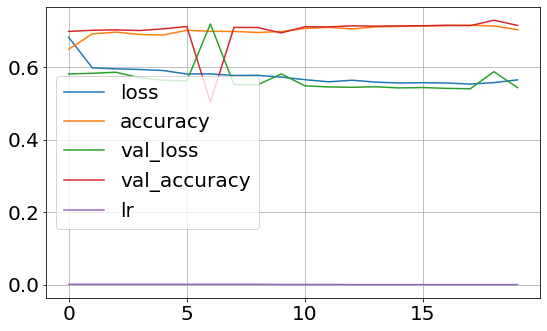

In [ ]:
import pandas as pd

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve.pdf')
plt.show()

#Testing

### Reshaping test features for label prediction

In [ ]:
X_test = df_test_der.to_numpy()
X_test = X_test.reshape(-1, 1, 13)

### Loading the saved model

In [ ]:
# Load the saved model
model.load_weights(filepath=abspath_curr + '/result/model/der_model.h5')

### Predicting values for the test dataset

In [ ]:
test_df_nor = normalize(df_test_der)

In [ ]:
test_pre = test_df_nor.reshape(-1, 1, 13)
model.load_weights(filepath=abspath_curr + '/result/model/der_model.h5')
prediction = model.predict(test_pre)
prediction =  np.where(prediction > 0.5, 1, 0)
prediction = pd.Series(prediction[:,0])

In [ ]:
prediction

0         1
1         1
2         1
3         1
4         1
         ..
549995    0
549996    0
549997    1
549998    0
549999    1
Length: 550000, dtype: int64

## Generating the submission file

In [ ]:
test_predict = pd.DataFrame({"EventId":test_data['EventId'],"Class":prediction})
test_predict['Class'] = test_predict['Class'].replace(0,'s')
test_predict['Class'] = test_predict['Class'].replace(1,'b')
test_predict.to_csv(abspath_curr+'submission.csv',index=False)

# Conclusion

We got the validation accuracy of:
- 75.86% when we considered all 30 features (primitive and derived)
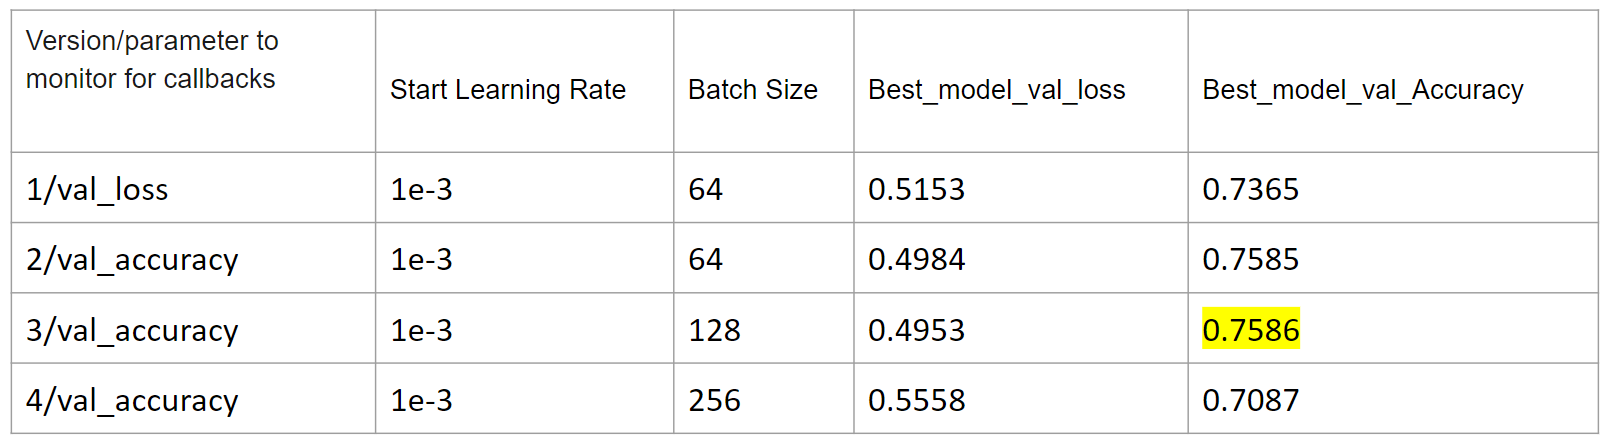
- 75.6% with just the 13 derived features
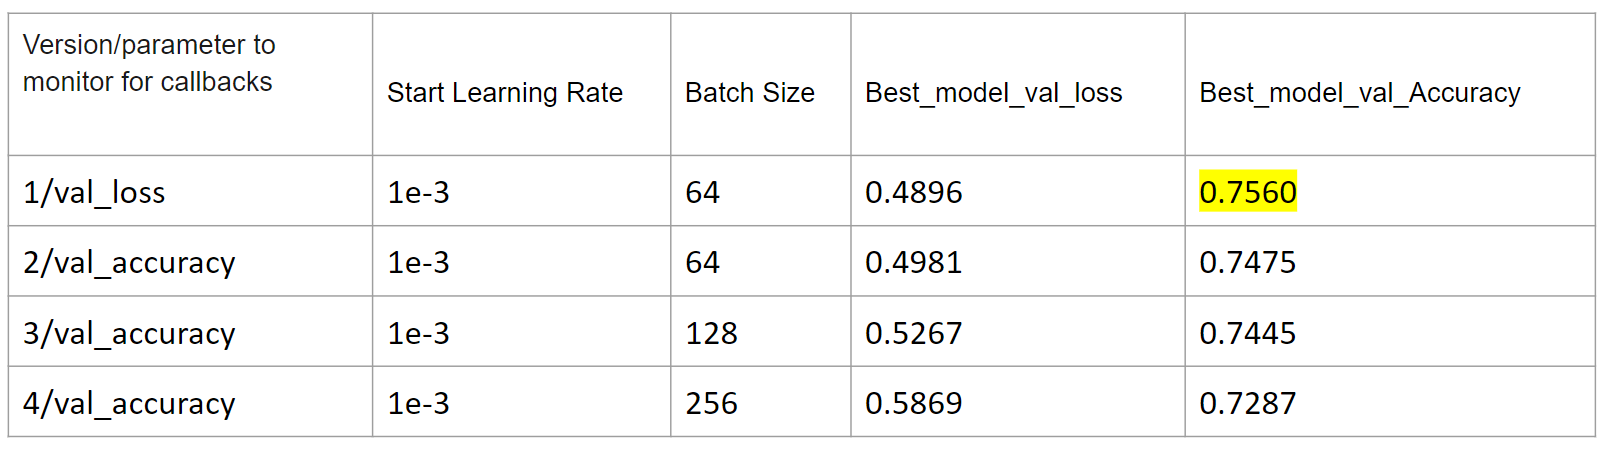
- 71.51% with just the 17 primitive features
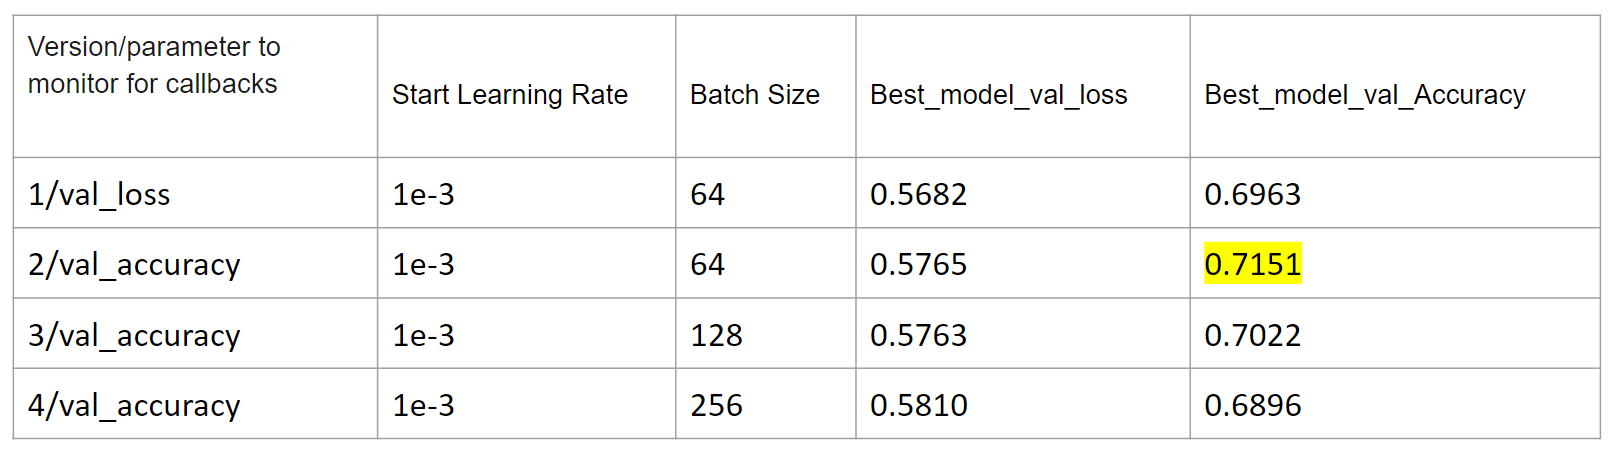

We consider the second experiment with derived features, the best because:
- Lower number of features
- Less computational cost
- Negligible loss of accuracy as compared to the best model


# Reference
- The case_study.ipynb file from p3_c2_s4_recurrent_neural_networks case_study folder from Professor Yuxiao Huang's GitHub was used as a reference to clean our data and build the above code.
- The code for building, compiling and training RNNs were largely inspired by the following work:
    - Géron, A., 2019. *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*. O'Reilly Media.